<a href="https://colab.research.google.com/github/Zhangln502/ML-Cyber-Security-Lab3/blob/main/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data and Test Model

In [1]:
import os
import sys
import gdown
import tempfile
import copy
import keras
import keras.backend as K
from keras import metrics
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

In [3]:
clean_data_filename = '/content/drive/MyDrive/MLSecuritylab3/valid.h5'
poisoned_data_filename = '/content/drive/MyDrive/MLSecuritylab3/bd_valid.h5'
model_filename = '/content/drive/MyDrive/MLSecuritylab3/bd_net.h5'
#bd_model.load_weights('/content/drive/MyDrive/MLSecuritylab3/bd_weights.h5')
cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)
bd_model = keras.models.load_model(model_filename)

In [4]:
# Evaluation function to get clean classification accuracy and the attack success rate
def evl(bd_model,cl_x_test,cl_y_test,bd_x_test,bd_y_test):
    # get the maximum value and thus get the predict label y
    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)
    
    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', asr)

In [5]:
# evaluate the base model: a backdoored neural network
evl(bd_model,cl_x_test,cl_y_test,bd_x_test,bd_y_test)

Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0


In [6]:
# to see the construction of the model
print(bd_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [7]:
# to find the layer we need to prune
print(bd_model.layers[5])

# Prune Model

In [9]:
# in order not to change the original model, we copy a new one and prune the model base on it
bd_model_copied = keras.models.clone_model(bd_model)
bd_model_copied.load_weights('/content/drive/MyDrive/MLSecuritylab3/bd_weights.h5')
# clean data accuracy from the previous calculation
original_acc = 98.64899974019225 

In [10]:
# decreasing order of average activation values over the entire validation set.
output=bd_model_copied.layers[6].output
prediction=keras.models.Model(inputs=bd_model_copied.input,outputs=output).predict(cl_x_test)  
avg_act_val = np.mean(prediction,axis=(0,1,2))
sorted_channels = np.argsort(avg_act_val)

In [11]:
# to see the sorted channels
sorted_channels

array([ 0, 26, 27, 30, 31, 33, 34, 36, 37, 38, 25, 39, 41, 44, 45, 47, 48,
       49, 50, 53, 55, 40, 24, 59,  9,  2, 12, 13, 17, 14, 15, 23,  6, 51,
       32, 22, 21, 20, 19, 43, 58,  3, 42,  1, 29, 16, 56, 46,  5,  8, 11,
       54, 10, 28, 35, 18,  4,  7, 52, 57])

In [12]:
# using the pruning defense to get new repaired model. That is, prune the last pooling layer of BadNet B
# by removing one channel at a time from that layer.  
temp_acc = []
as_rate = []
XX = [] 
X2 = 1
X5 = 1
X10 = 1
zeroWeight = bd_model_copied.layers[5].get_weights()[0]
zeroBias = bd_model_copied.layers[5].get_weights()[1]
# go through all channels in the layer
for i in sorted_channels:
  # set the weights of specific channel to zero, that is prune process
  zeroWeight[:,:,:,i] = 0
  zeroBias[i] = 0
  bd_model_copied.layers[5].set_weights([zeroWeight,zeroBias])
  
  # get the accuracy and attack success rate and save the value to array
  temp_accuracy = np.mean(np.equal(np.argmax(bd_model_copied.predict(cl_x_test), axis=1), cl_y_test))*100
  asr = np.mean(np.equal(np.argmax(bd_model_copied.predict(bd_x_test), axis=1), bd_y_test))*100
  temp_acc.append(temp_accuracy)
  as_rate.append(asr)
  print("channel ",i,": ","The accuracy: ",temp_accuracy,"  The atk_rate: ",asr)

# measure the new validation accuracy of the new pruned badnet.
  X = original_acc - temp_accuracy
  XX.append(X)

  if X >= 2 and X2:
    # once the accuracy satisfy some value, we save the model to a file for future use
    bd_model_copied.save('/content/drive/MyDrive/MLSecuritylab3/bd_model_X2.h5')
    X2 = 0
    print('save model_X2')
  if X >= 5 and X5:
    bd_model_copied.save('/content/drive/MyDrive/MLSecuritylab3/bd_model_X5.h5')
    X5 = 0
    print('save model_X5')
  if X >= 10 and X10:
    bd_model_copied.save('/content/drive/MyDrive/MLSecuritylab3/bd_model_X10.h5')
    X10 = 0
    print('save model_X10')

  keras.backend.clear_session()


channel  0 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  26 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  27 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  30 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  31 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  33 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  34 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  36 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  37 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  38 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  25 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  39 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  41 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  44 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


save model_X2
channel  16 :  The accuracy:  95.20221702606739   The atk_rate:  99.9913397419243
channel  56 :  The accuracy:  94.7172425738287   The atk_rate:  99.9913397419243
channel  46 :  The accuracy:  92.09318437689443   The atk_rate:  99.9913397419243
save model_X5
channel  5 :  The accuracy:  91.49562656967177   The atk_rate:  99.9913397419243
channel  8 :  The accuracy:  91.01931237550879   The atk_rate:  99.98267948384861
channel  11 :  The accuracy:  89.17467740538669   The atk_rate:  80.73958603966398
channel  54 :  The accuracy:  84.43751623798389   The atk_rate:  77.015675067117
save model_X10
channel  10 :  The accuracy:  76.48739932449988   The atk_rate:  35.71490430414826
channel  28 :  The accuracy:  54.8627349095003   The atk_rate:  6.954187234779596
channel  35 :  The accuracy:  27.08928726076037   The atk_rate:  0.4243526457088421
channel  18 :  The accuracy:  13.87373343725643   The atk_rate:  0.0
channel  4 :  The accuracy:  7.101411622066338   The atk_rate:  0.0

# Good Net

In [14]:
# find out how many labels are there in test data
from numpy.lib.arraysetops import unique
cl_y_test.shape
unique_y = set(cl_y_test)  
print(len(unique_y))

1283


In [15]:
# the class of goodnet
class gdnet(keras.Model):
  def __init__(self, bd_m, bd_pm):
      super(gdnet,self).__init__()
      self.bd_m = bd_m
      self.bd_pm = bd_pm

  def predict(self,inputX):
      # prediction 
      bd_m_y = np.argmax(self.bd_m.predict(inputX), axis=1)
      bd_pm_y = np.argmax(self.bd_pm.predict(inputX), axis=1)
      y = np.zeros(len(bd_m_y))
      for i in range(len(bd_m_y)):
        #if the two prediction label differs, we output the N+1 class
        if bd_m_y[i] != bd_pm_y[i]:
          y[i] = 1284  
        #if the two prediction label are the same, we output the one of them
        else:
          y[i] = bd_m_y[i]
      return y

# Evaluation on new model

In [16]:
# Te second version Evaluation function for goodnet to get clean classification accuracy and the attack success rate
def evl2(bd_model,cl_x_test,cl_y_test,bd_x_test,bd_y_test):
    cl_label_p = bd_model.predict(cl_x_test)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)
    
    bd_label_p = bd_model.predict(bd_x_test)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', asr)

In [17]:
bd_test, bd_test_l = data_loader('/content/drive/MyDrive/MLSecuritylab3/bd_test.h5')
test, test_l = data_loader('/content/drive/MyDrive/MLSecuritylab3/test.h5')

bd_model_X2 = keras.models.load_model('/content/drive/MyDrive/MLSecuritylab3/bd_model_X2.h5')
bd_model_X4 = keras.models.load_model('/content/drive/MyDrive/MLSecuritylab3/bd_model_X5.h5')
bd_model_X10 = keras.models.load_model('/content/drive/MyDrive/MLSecuritylab3/bd_model_X10.h5')

In [18]:
# The evaluation on pruned network
evl(bd_model_X2,test,test_l,bd_test,bd_test_l)
evl(bd_model_X4,test,test_l,bd_test,bd_test_l)
evl(bd_model_X10,test,test_l,bd_test,bd_test_l)

Clean Classification accuracy: 95.90023382696803
Attack Success Rate: 100.0
Clean Classification accuracy: 92.29150428682775
Attack Success Rate: 99.98441153546376
Clean Classification accuracy: 84.54403741231489
Attack Success Rate: 77.20966484801247


In [19]:
gd_X2_model = gdnet(bd_model, bd_model_X2)
gd_X4_model = gdnet(bd_model, bd_model_X4)
gd_X10_model = gdnet(bd_model, bd_model_X10)

In [20]:
# The evaluation on repaired network Goodnet
print('For X=2% Repaired Model: ')
evl2(gd_X2_model,test,test_l,bd_test,bd_test_l)
print('For X=4% Repaired Model: ')
evl2(gd_X4_model,test,test_l,bd_test,bd_test_l)
print('For X=10% Repaired Model: ')
evl2(gd_X10_model,test,test_l,bd_test,bd_test_l)

For X=2% Repaired Model: 
Clean Classification accuracy: 95.74434918160561
Attack Success Rate: 100.0
For X=4% Repaired Model: 
Clean Classification accuracy: 92.1278254091972
Attack Success Rate: 99.98441153546376
For X=10% Repaired Model: 
Clean Classification accuracy: 84.3335931410756
Attack Success Rate: 77.20966484801247


# Accuaracy of pruned channels 

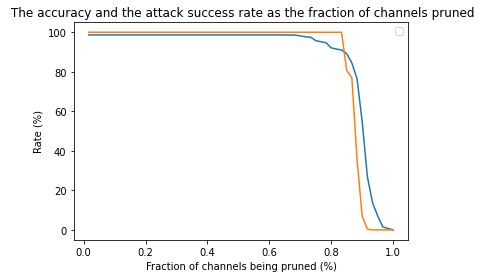

In [21]:
# the x axiel is actually from 1 to 60 and divide 60
x_axis = np.arange(1,61)/60
plt.title(" The accuracy and the attack success rate as the fraction of channels pruned")
plt.xlabel("Fraction of channels being pruned (%)")
plt.ylabel("Rate (%)")
plt.legend(['The accuracy','The attack success'])
plt.plot(x_axis,temp_acc)
plt.plot(x_axis,as_rate)

In [22]:
# to find the first point when X equals or large than 30%
for i in range(len(XX)):
  if XX[i] >= 30:
    print("The attack success rate for X=30% is : ", as_rate[i])
    break

The attack success rate for X=30% is :  6.954187234779596


# Conclusion

From the first beginning, before the pruning defense, the accuracy is 98.65
and the Attack Success Rate is 100.0. And from the Evaluation part, we can see that if we prune the channel a little bit, The effect is not very obvious. As the number of channel pruned increase, the attack success rate decrease. And the attack success rate decrease a lot when we prune a lot of channels. However, the accuracy decrease a lot, too. Also, from the plot above, we can see that there is no big 'green space' like the space in the following picture. That is, backdoor diasabled with compromising clean set accuracy. So I think the pruning defense actually doen not works for this model. And this may because the attacker(this bd_model) adapts to this defense, that is, adaptive attacker introduces sacrificial neurons in the network to diable pruning defense. And that's why we didn't see obvious effect of our defense methods.




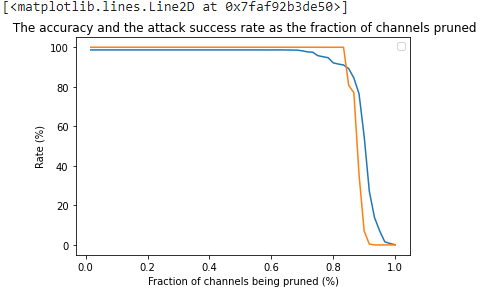
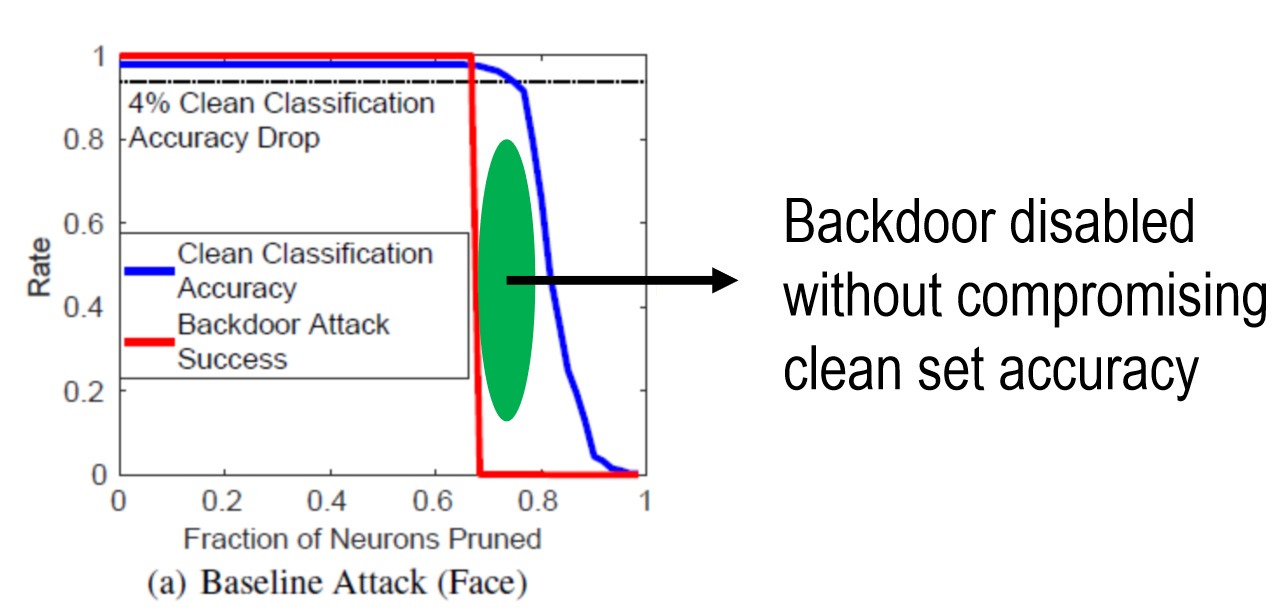